# Pneumonia X-Ray Image Classification: Modeling

Authors:
- Arthur Kim
    - Github: arthurk2323
- Mia Fryer
    - Github: miazfryer
- Ian Sharff
    - Github: iansharff
___

This notebook contains the raw code used to define, compile, train, and evaluate the neural network models used to classify chest X-ray images as positive or negative for pneumonia infection. As such, these are _binary_ classifiers, and are evaluated on the basis of their accuracy and recall in comparison to the baseline.

For each model, a confusion matrix and accuracy/loss plots were created to visualize the performance of the model over time and at completion of training.

__Note:__ Running this notebook in its entirety should take around 30-45 minutes or more. When run, each trained model will be saved and a dictionary of its history attribute will be saved for use in other notebooks. For quicker execution (but weaker performing models) assign `EPOCHS` a lower integer value.

## Data Preparation and Loading

In [1]:
# File/path/directory reading and writing
import os
import sys
import pickle
import cv2

# Arrays/Tabular data
import numpy as np
import pandas as pd

# Visualizations and style sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('images/presentation.mplstyle')

# Neural network models and layers
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img
)
from tensorflow.keras.models import load_model

# Model evaluation metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Custom functions
import tools.visualizations as vis
import tools.misc as misc

In [2]:
# Functions for writing and reading pickle files, also available in tools.misc
def pickle_history(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model.history, f)

def unpickle_history(filepath):
    with open(filepath, 'rb') as f:
        history = pickle.load(f)
    return history

Here, global constants are defined for image resolution, file paths, batch size, and the number of training epochs. Data subset counts are returned as a dictionary by the `misc.count_files` function, which demonstrates the large class imbalance present the dataset.

In [3]:
# Path Constants
TRAIN_PATH = 'data/split/train'
VAL_PATH = 'data/split/val'
TEST_PATH = 'data/split/test'

# Image Processing Constants
BATCH_SIZE = 32
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Change for test runs
EPOCHS = 30

In [4]:
# Call function to display counts and return dict of subtotals
counts = misc.count_files([TRAIN_PATH, VAL_PATH, TEST_PATH])

TRAIN
-------------------------
	PNEUMONIA: 2564
	NORMAL: 950

	SUBTOTAL: 3514
VAL
-------------------------
	PNEUMONIA: 855
	NORMAL: 317

	SUBTOTAL: 1172
TEST
-------------------------
	PNEUMONIA: 854
	NORMAL: 316

	SUBTOTAL: 1170
-------------------------
TOTAL: 5856 files


In [5]:
counts

{'train': 3514, 'val': 1172, 'test': 1170}

Here, the images are accessed through `ImageDataGenerator`s and rescaled. The batch sizees are set to the file count for a given subset (training, validation, and testing) within the `flow_from_directory` method call, so all images are saved to memory as 64x64 grayscale images (shape = (n_images, 64, 64, 1)) upon calling `next` on the `DirectoryIterators` produced.

To maintain consistency between sets, the parameters are set in `gen_params`. 

In [6]:
# DirectoryIterator parameters for flow_from_directory
gen_params = {
    'target_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'color_mode': 'grayscale',
    'class_mode': 'binary',
}

In [7]:
# Load 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_PATH, 
    batch_size=counts['train'],
    **gen_params
)

# Get all the data in the directory data/val (855+317 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_PATH, 
    batch_size=counts['val'],
    **gen_params
)

# Get all the data in the directory data/test (854+316 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_PATH,
    batch_size=counts['test'],
    **gen_params
)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


Here, the generators were used to load the entire datasets into memory. While this is possible with the current size of the data, this will be very computationally expensive when scaling up which will require a smaller proportional batch size.

In [8]:
# Create the datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [9]:
# Display the shape of the image and label arrays
print('TRAIN\n' + '-'*50)
print(f'\ttrain_images shape: {train_images.shape}')
print(f'\ttrain_labels shape: {train_labels.shape}')
print('\nVALIDATION\n' + '-'*50)
print(f'\tval_images shape: {val_images.shape}')
print(f'\tval_labels shape: {val_labels.shape}')
print('\nTEST\n' + '-'*50)
print(f'\ttest_images shape: {test_images.shape}')
print(f'\ttest_labels shape: {test_labels.shape}')

TRAIN
--------------------------------------------------
	train_images shape: (3514, 64, 64, 1)
	train_labels shape: (3514,)

VALIDATION
--------------------------------------------------
	val_images shape: (1172, 64, 64, 1)
	val_labels shape: (1172,)

TEST
--------------------------------------------------
	test_images shape: (1170, 64, 64, 1)
	test_labels shape: (1170,)


To account for the class imbalance evident in the dataset, we calculate the class weights to pass into the neural network's `.fit()` calls which ideally would improve a given model's performance and reduce overfitting. 

In [10]:
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels,
)

In [11]:
class_names = {v: k for k, v in train_generator.class_indices.items()}
print(class_names)

{0: 'NORMAL', 1: 'PNEUMONIA'}


#### Sample Images

In [12]:
vir_samples = [
    'data/VIRUS/person1_virus_11.jpeg',
    'data/VIRUS/person1_virus_12.jpeg',
    'data/VIRUS/person1_virus_13.jpeg',
]

bac_samples = [
    'data/BACTERIA/person1_bacteria_1.jpeg',
    'data/BACTERIA/person1_bacteria_2.jpeg',
    'data/BACTERIA/person10_bacteria_43.jpeg'
]

norm_samples = [
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg',
    'data/NORMAL/IM-0001-0001.jpeg'
]

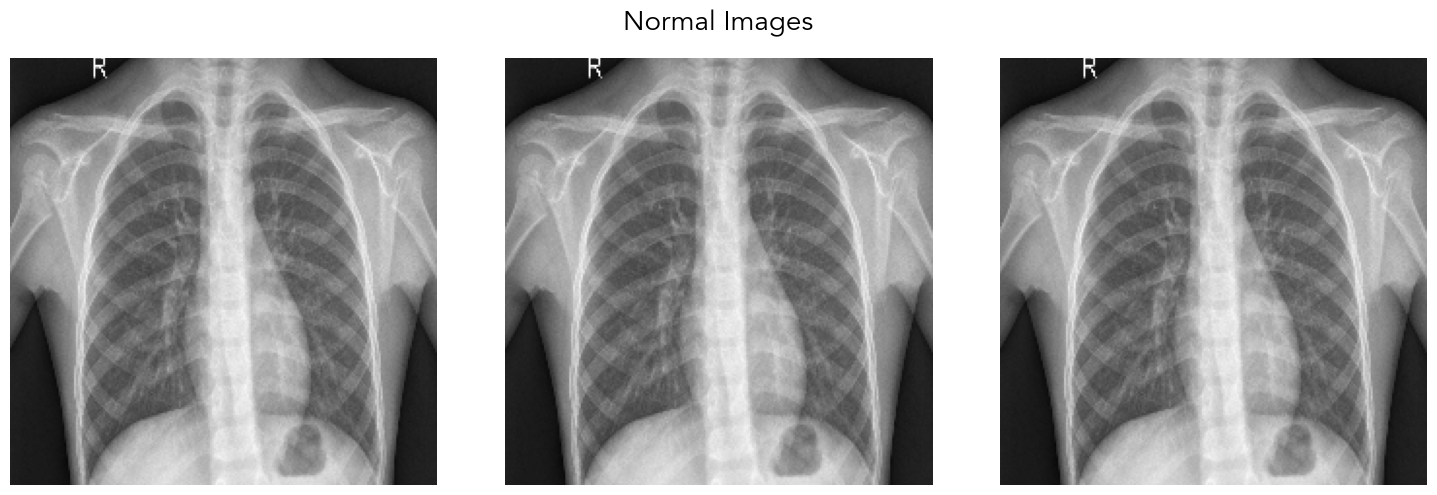

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(norm_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Normal Images")
fig.tight_layout()       
plt.savefig('images/norm_samples.png')
plt.show()

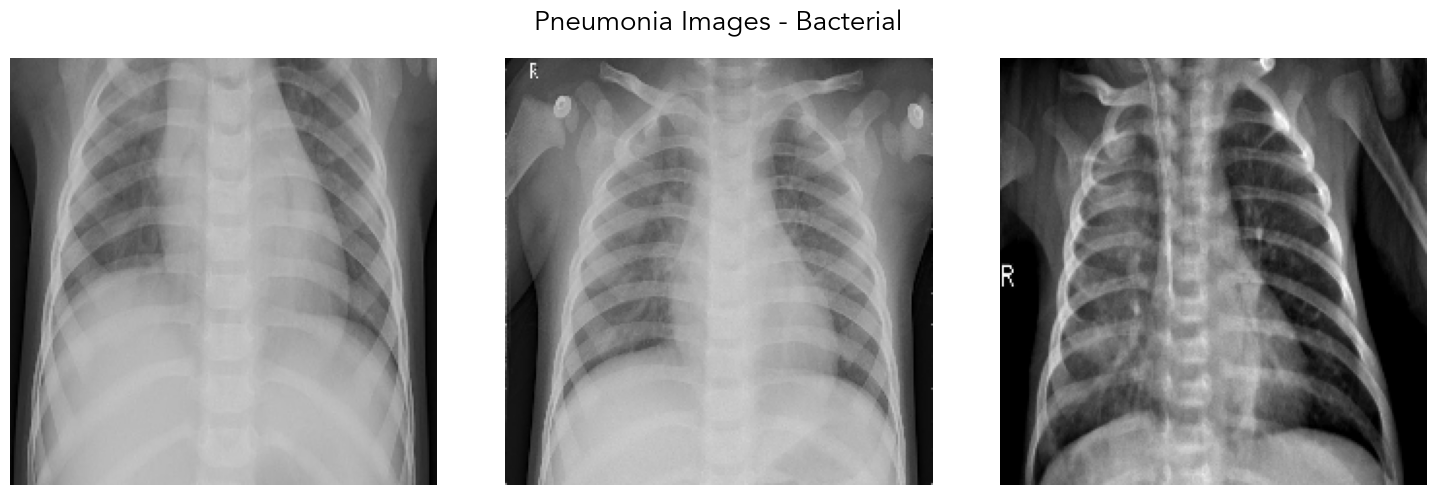

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(bac_samples[i])
    img = cv2.resize(img, (220,220))
    ax.imshow(img)
    ax.axis("off")
fig.suptitle("Pneumonia Images - Bacterial")
fig.tight_layout()
plt.savefig('images/bac_samples.png')
plt.show()

## Model Building and Evaluation

We first create a "dummy" model to determine the baseline metrics by which we will evaluate the models. Here, we defined a `DummyClassifier` with a stratified strategy to take the data's class imbalance into account. This leaves us with baseline recall and accuracy scores of 73% and 61%, respectively, for the binary classification of pneumonia vs. normal lung X-rays. 

### Dummy Model

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(train_images, train_labels)
dummy_pred = dummy_clf.predict(train_images)

print(classification_report(train_labels, dummy_pred))

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28       950
         1.0       0.73      0.73      0.73      2564

    accuracy                           0.61      3514
   macro avg       0.51      0.51      0.51      3514
weighted avg       0.61      0.61      0.61      3514



### Model 1: Baseline Neural Network

In [16]:
np.random.seed(123)
model1 = models.Sequential()
model1.add(layers.Flatten(input_shape=(64, 64, 1)))
model1.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history1 = model1.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

pickle_history(history1, 'models/model1_hist.pkl')

Epoch 1/30
110/110 [==============================] - 1s 4ms/step - loss: 0.5962 - acc: 0.7278 - val_loss: 0.4785 - val_acc: 0.7423
Epoch 2/30
110/110 [==============================] - 0s 852us/step - loss: 0.3735 - acc: 0.8522 - val_loss: 0.2733 - val_acc: 0.9070
Epoch 3/30
110/110 [==============================] - 0s 817us/step - loss: 0.2670 - acc: 0.8985 - val_loss: 0.2646 - val_acc: 0.9053
Epoch 4/30
110/110 [==============================] - 0s 844us/step - loss: 0.2531 - acc: 0.8991 - val_loss: 0.2434 - val_acc: 0.9078
Epoch 5/30
110/110 [==============================] - 0s 809us/step - loss: 0.2235 - acc: 0.9152 - val_loss: 0.2426 - val_acc: 0.9053
Epoch 6/30
110/110 [==============================] - 0s 839us/step - loss: 0.2305 - acc: 0.9081 - val_loss: 0.2190 - val_acc: 0.9206
Epoch 7/30
110/110 [==============================] - 0s 849us/step - loss: 0.2107 - acc: 0.9144 - val_loss: 0.2584 - val_acc: 0.8891
Epoch 8/30
110/110 [==============================] - 0s 833us/s

In [18]:
model1.save('models/model1.h5')

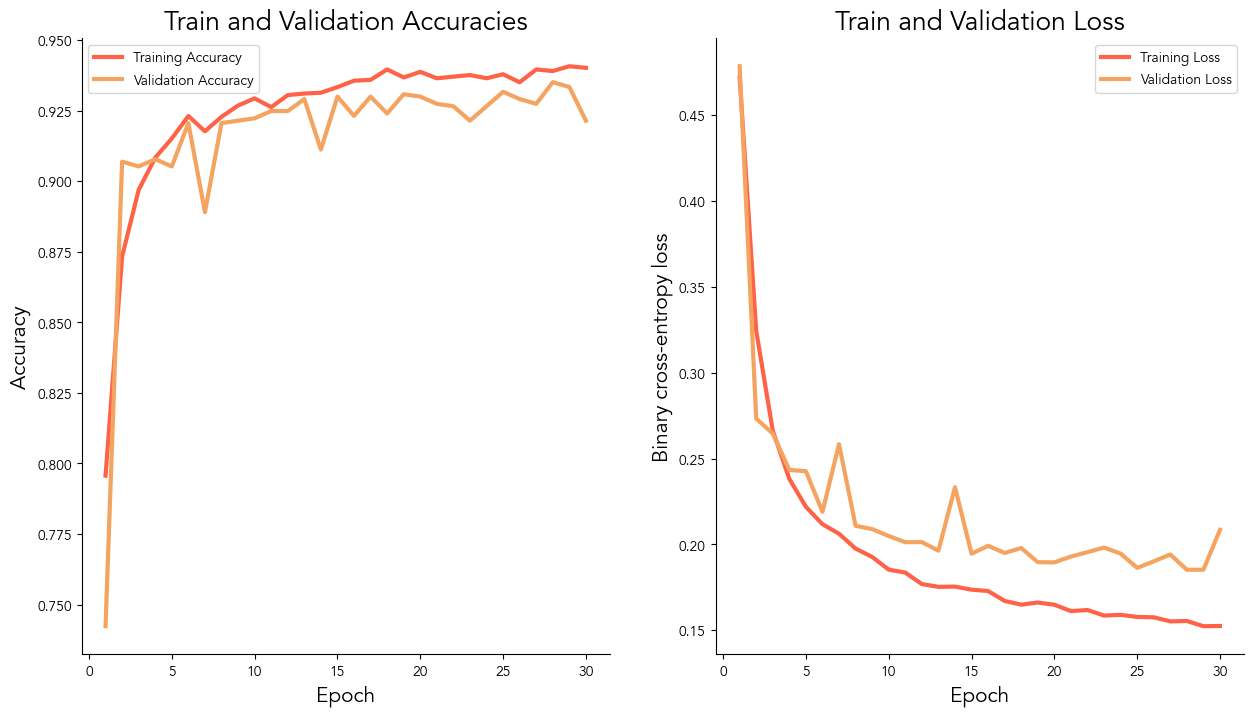

In [19]:
vis.plot_loss_accuracy(history1)
plt.savefig('images/acc_loss/al_model1.png')
plt.show()

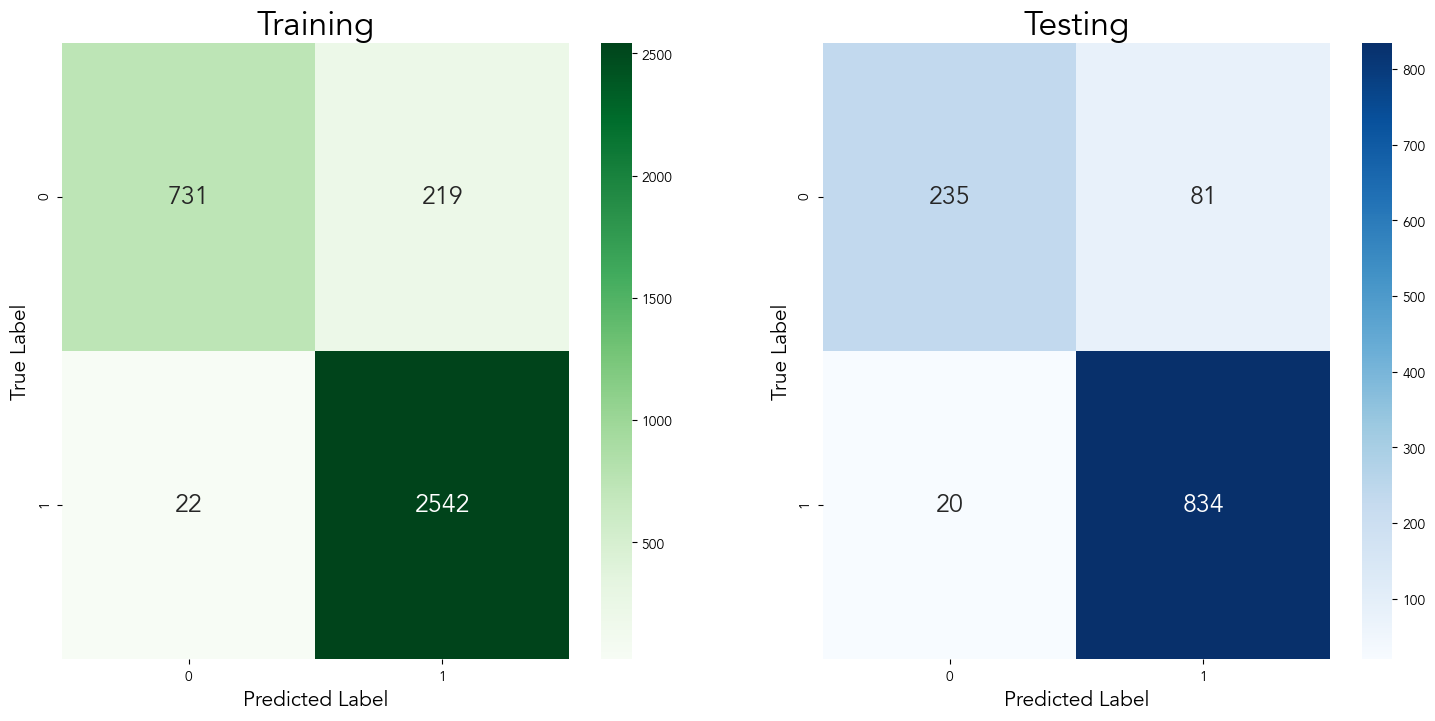

In [20]:
vis.plot_confusion_matrices(model1, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model1.png')
plt.show()

In [21]:
results_train = model1.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 451us/step - loss: 0.1760 - acc: 0.9314


In [22]:
results_test = model1.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 443us/step - loss: 0.2112 - acc: 0.9137


In [23]:
results_train

[0.1759590208530426, 0.9314171671867371]

In [24]:
results_test

[0.21122516691684723, 0.9136751890182495]

### Model 2: Neural Network with Dense Layers

In [25]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(64, 64, 1)))
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history2 = model2.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

pickle_history(history2, 'models/model2_hist.pkl')

Epoch 1/30
110/110 [==============================] - 1s 5ms/step - loss: 0.6274 - acc: 0.7134 - val_loss: 0.5288 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 0s 4ms/step - loss: 0.4946 - acc: 0.7732 - val_loss: 0.3846 - val_acc: 0.8643
Epoch 3/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3805 - acc: 0.8447 - val_loss: 0.2990 - val_acc: 0.8942
Epoch 4/30
110/110 [==============================] - 0s 5ms/step - loss: 0.3171 - acc: 0.8723 - val_loss: 0.2543 - val_acc: 0.9070
Epoch 5/30
110/110 [==============================] - 0s 4ms/step - loss: 0.2716 - acc: 0.8950 - val_loss: 0.3107 - val_acc: 0.8652
Epoch 6/30
110/110 [==============================] - 0s 4ms/step - loss: 0.2644 - acc: 0.8994 - val_loss: 0.3111 - val_acc: 0.8712
Epoch 7/30
110/110 [==============================] - 0s 4ms/step - loss: 0.2282 - acc: 0.9120 - val_loss: 0.2504 - val_acc: 0.8968
Epoch 8/30
110/110 [==============================] - 0s 4ms/step - loss: 0.

In [27]:
# Save model
model2.save('models/model2.h5')

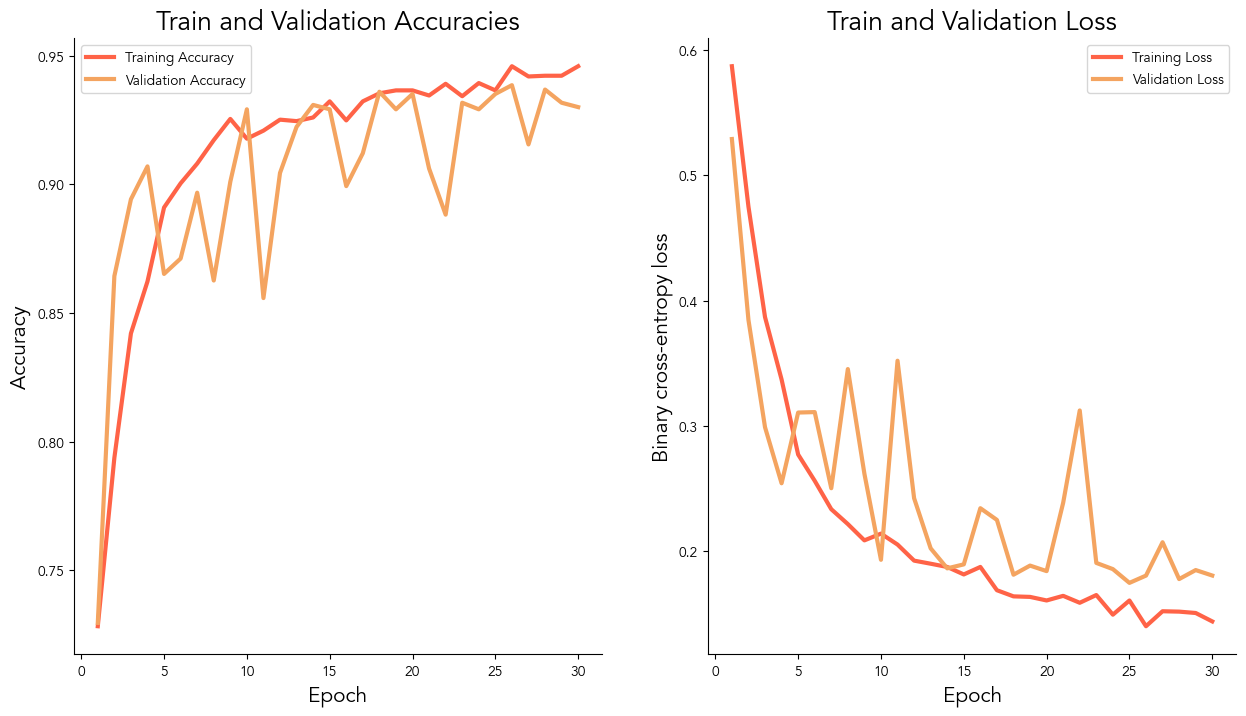

In [28]:
vis.plot_loss_accuracy(history2)
plt.savefig('images/acc_loss/al_model2.png')
plt.show()

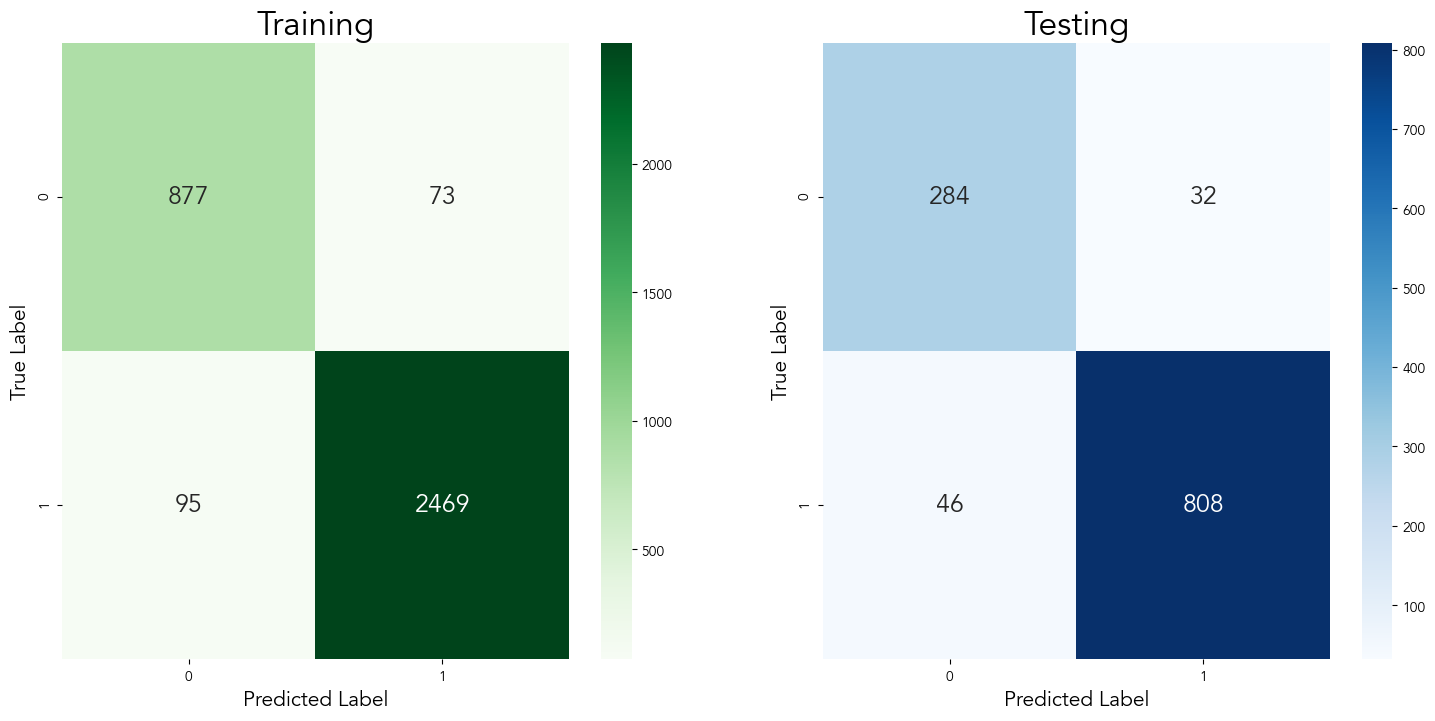

In [29]:
vis.plot_confusion_matrices(model2, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model2.png')
plt.show()

In [30]:
results_train = model2.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.1267 - acc: 0.9522


In [31]:
results_test = model2.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.1783 - acc: 0.9333


In [32]:
results_train

[0.12671920657157898, 0.9521912336349487]

In [33]:
results_test

[0.17828650772571564, 0.9333333373069763]

### Model 3: Neural Network with Dense and Drop Layers

In [34]:
np.random.seed(123)
model3 = models.Sequential()
model3.add(layers.Flatten(input_shape=(64, 64, 1)))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(25, activation='relu'))
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(7, activation='relu'))
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_images,
                     train_labels,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=(val_images, val_labels))

pickle_history(history3, 'models/model3_hist.pkl')

Epoch 1/30
110/110 [==============================] - 1s 5ms/step - loss: 0.5958 - acc: 0.7262 - val_loss: 0.4591 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 0s 4ms/step - loss: 0.4614 - acc: 0.7436 - val_loss: 0.3603 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3999 - acc: 0.7360 - val_loss: 0.3731 - val_acc: 0.8899
Epoch 4/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3586 - acc: 0.8029 - val_loss: 0.3110 - val_acc: 0.9104
Epoch 5/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3360 - acc: 0.8825 - val_loss: 0.3481 - val_acc: 0.8652
Epoch 6/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3131 - acc: 0.8938 - val_loss: 0.3083 - val_acc: 0.9019
Epoch 7/30
110/110 [==============================] - 0s 4ms/step - loss: 0.3021 - acc: 0.8953 - val_loss: 0.2991 - val_acc: 0.8985
Epoch 8/30
110/110 [==============================] - 0s 4ms/step - loss: 0.

In [36]:
model3.save('models/model3.h5')

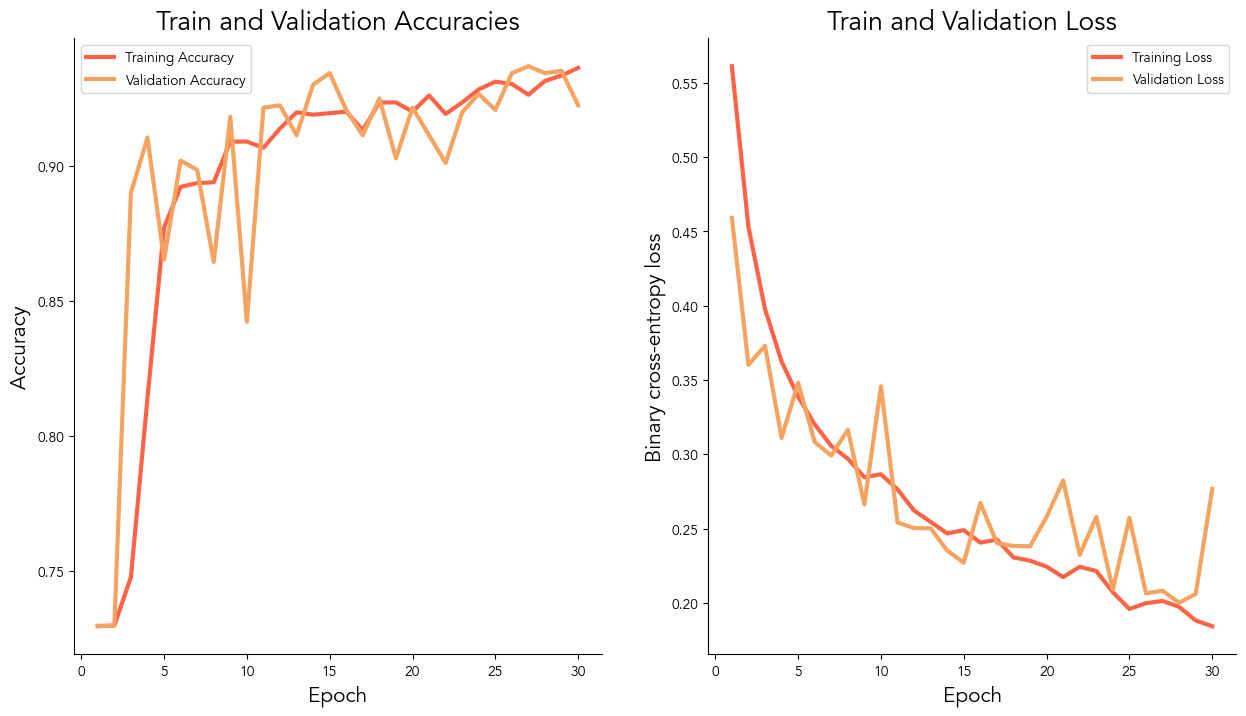

In [37]:
vis.plot_loss_accuracy(history3)
plt.savefig('images/acc_loss/al_model3.png')
plt.show()

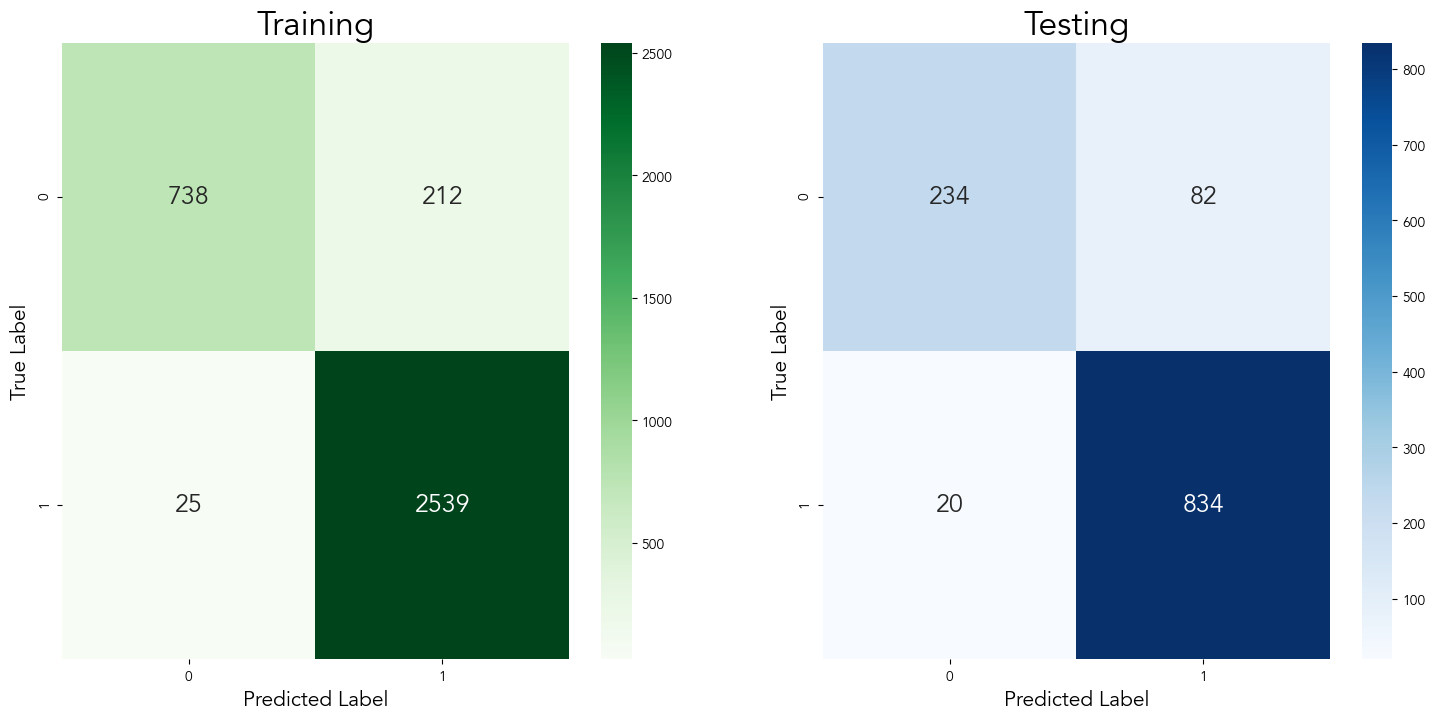

In [38]:
vis.plot_confusion_matrices(model3, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model3.png')
plt.show()

In [39]:
results_train = model3.evaluate(train_images, train_labels)

110/110 [==============================] - 0s 2ms/step - loss: 0.2077 - acc: 0.9326


In [40]:
results_test = model3.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 2ms/step - loss: 0.2680 - acc: 0.9128


In [41]:
results_train

[0.2077273577451706, 0.9325554966926575]

In [42]:
results_test

[0.2679988741874695, 0.9128205180168152]

### Model 4: Convolutional Neural Network (CNN)

In [43]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [44]:
history4 = model4.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

pickle_history(history4, 'models/model4_hist.pkl')

Epoch 1/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6046 - acc: 0.7378 - val_loss: 0.5842 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 6s 55ms/step - loss: 0.5962 - acc: 0.7153 - val_loss: 0.5751 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 7s 61ms/step - loss: 0.5702 - acc: 0.7314 - val_loss: 0.5580 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 67ms/step - loss: 0.5546 - acc: 0.7276 - val_loss: 0.5164 - val_acc: 0.7304
Epoch 5/30
110/110 [==============================] - 8s 70ms/step - loss: 0.5134 - acc: 0.7364 - val_loss: 0.4713 - val_acc: 0.7338
Epoch 6/30
110/110 [==============================] - 7s 66ms/step - loss: 0.4558 - acc: 0.7800 - val_loss: 0.3844 - val_acc: 0.8729
Epoch 7/30
110/110 [==============================] - 8s 69ms/step - loss: 0.3981 - acc: 0.8354 - val_loss: 0.2897 - val_acc: 0.8788
Epoch 8/30
110/110 [==============================] - 9s 80ms/step - 

In [45]:
model4.save('models/model4.h5')

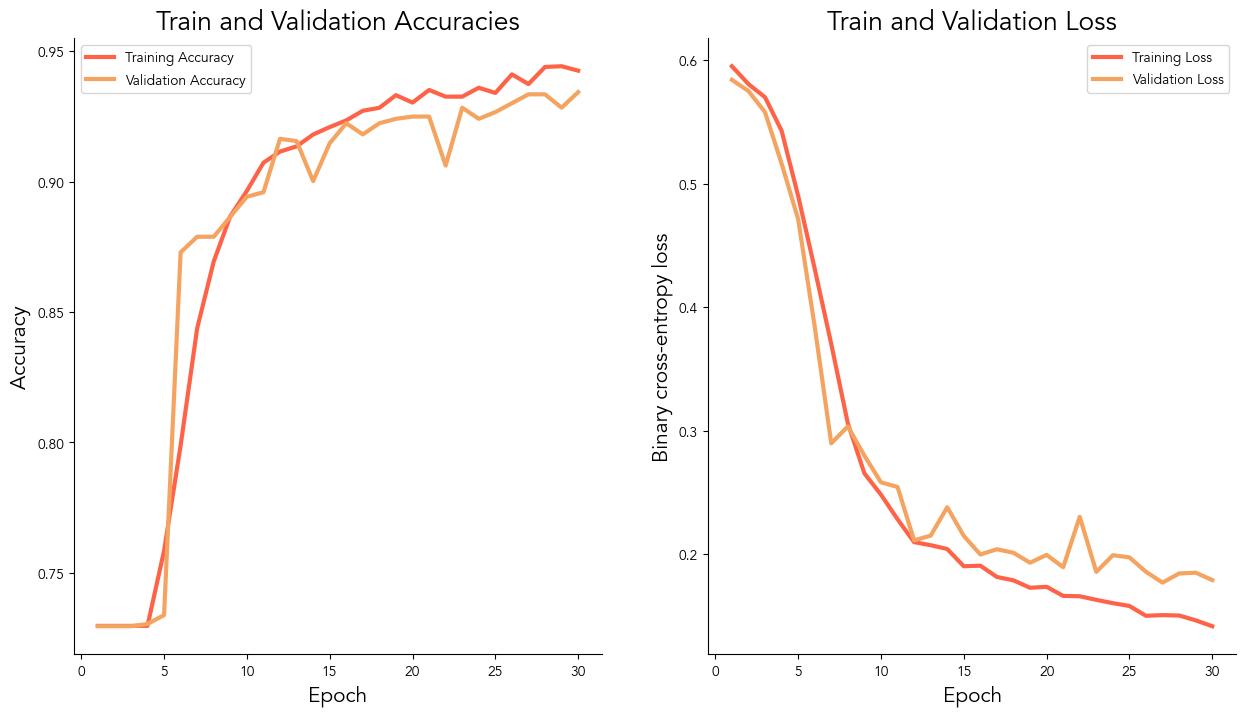

In [46]:
vis.plot_loss_accuracy(history4)
plt.savefig('images/acc_loss/al_model4.png')
plt.show()

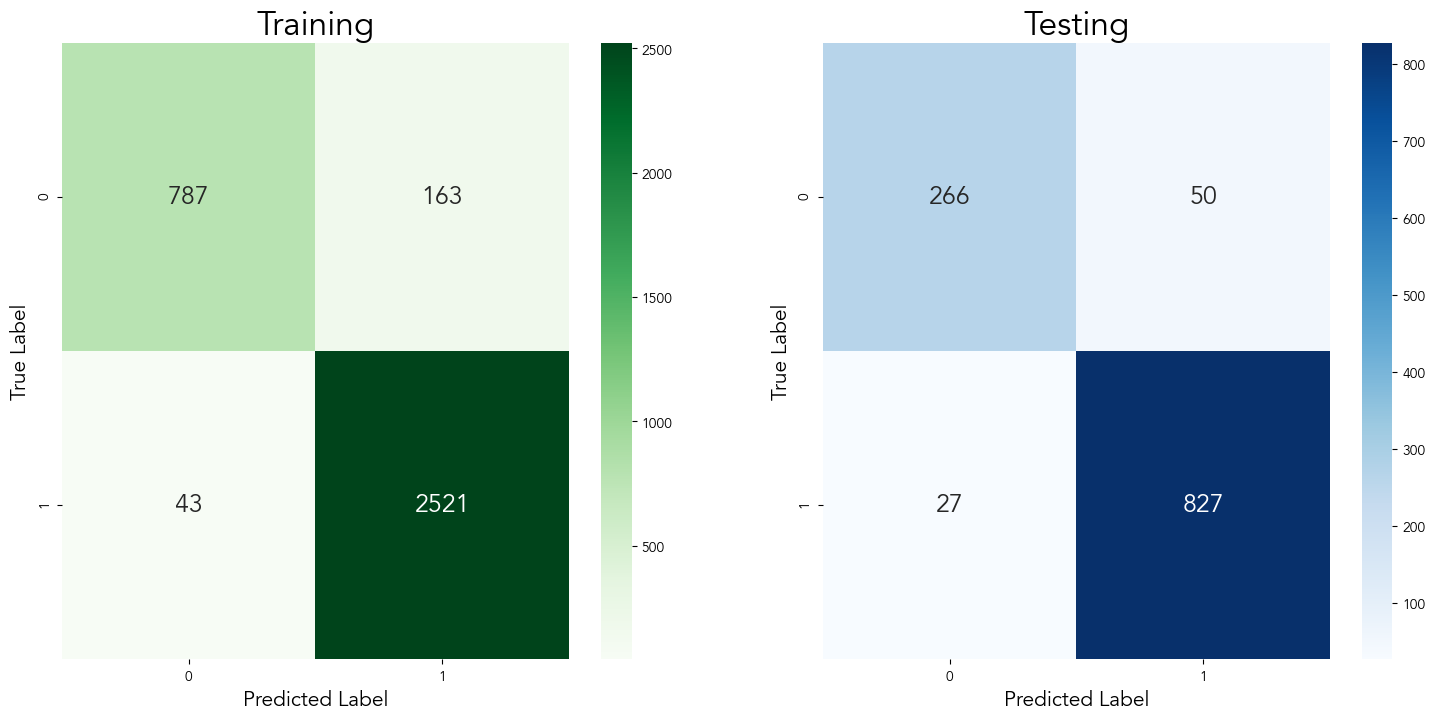

In [47]:
vis.plot_confusion_matrices(model4, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model4.png')
plt.show()

In [48]:
results_train = model4.evaluate(train_images, train_labels)

110/110 [==============================] - 2s 15ms/step - loss: 0.1417 - acc: 0.9414


In [49]:
results_test = model4.evaluate(test_images, test_labels)

37/37 [==============================] - 1s 15ms/step - loss: 0.1753 - acc: 0.9342


In [50]:
results_train

[0.14166557788848877, 0.9413773417472839]

In [51]:
results_test

[0.17534607648849487, 0.9341880083084106]

### Model 4.1: Base CNN with Class Weights

In [52]:
class_weight_dict = dict(zip([0, 1], class_weight))
class_weight_dict

{0: 1.8494736842105264, 1: 0.6852574102964119}

In [53]:
model4_1 = models.Sequential()
model4_1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))

model4_1.add(layers.Flatten())
model4_1.add(layers.Dense(64, activation='relu'))
model4_1.add(layers.Dense(1, activation='sigmoid'))

model4_1.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [54]:
history4_1 = model4_1.fit(train_images,
                    train_labels,
                    class_weight=class_weight_dict,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_labels))

pickle_history(history4_1, 'models/model4_1_hist.pkl')

Epoch 1/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6835 - acc: 0.6805 - val_loss: 0.7044 - val_acc: 0.2713
Epoch 2/30
110/110 [==============================] - 7s 60ms/step - loss: 0.6746 - acc: 0.5016 - val_loss: 0.6620 - val_acc: 0.7577
Epoch 3/30
110/110 [==============================] - 7s 63ms/step - loss: 0.6260 - acc: 0.8076 - val_loss: 0.5603 - val_acc: 0.8677
Epoch 4/30
110/110 [==============================] - 7s 67ms/step - loss: 0.5404 - acc: 0.7939 - val_loss: 0.3734 - val_acc: 0.8763
Epoch 5/30
110/110 [==============================] - 6s 59ms/step - loss: 0.4334 - acc: 0.8154 - val_loss: 0.7481 - val_acc: 0.6169
Epoch 6/30
110/110 [==============================] - 6s 59ms/step - loss: 0.3374 - acc: 0.8599 - val_loss: 0.3073 - val_acc: 0.8626
Epoch 7/30
110/110 [==============================] - 7s 61ms/step - loss: 0.2885 - acc: 0.8802 - val_loss: 0.2402 - val_acc: 0.8959
Epoch 8/30
110/110 [==============================] - 7s 60ms/step - 

In [55]:
model4_1.save('models/model4_1.h5')

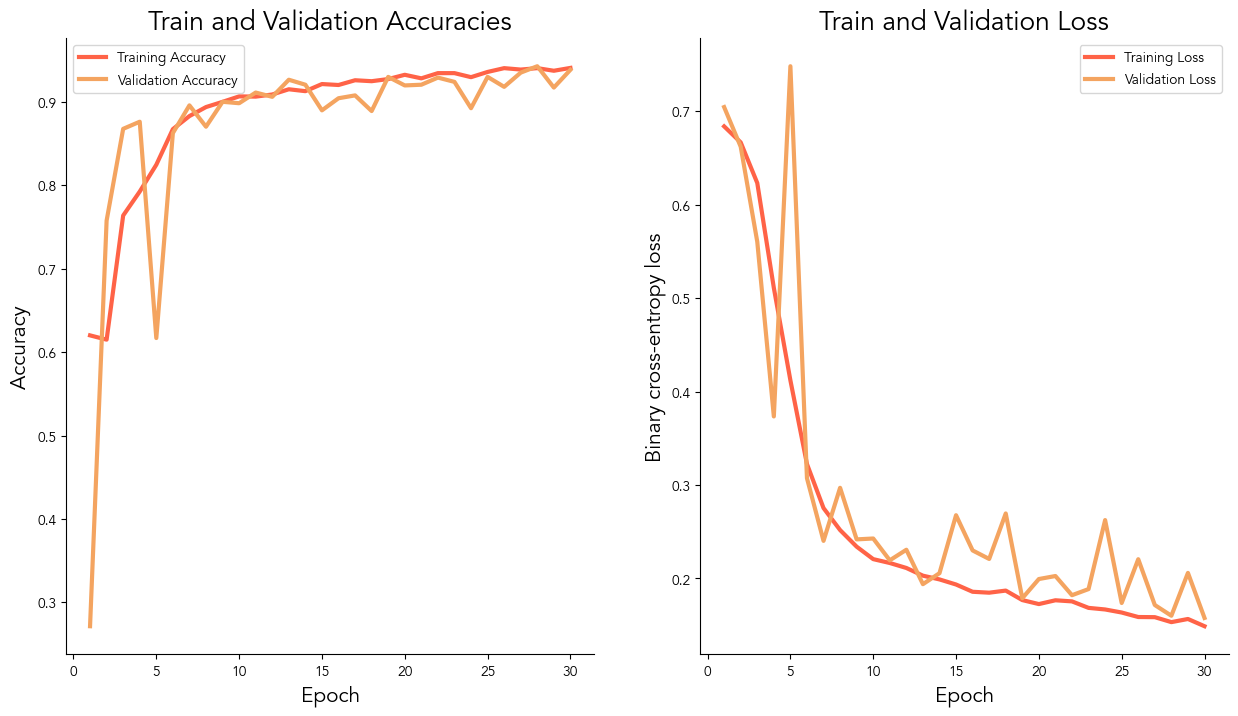

In [56]:
vis.plot_loss_accuracy(history4_1)
plt.savefig('images/acc_loss/al_model4_1.png')
plt.show()

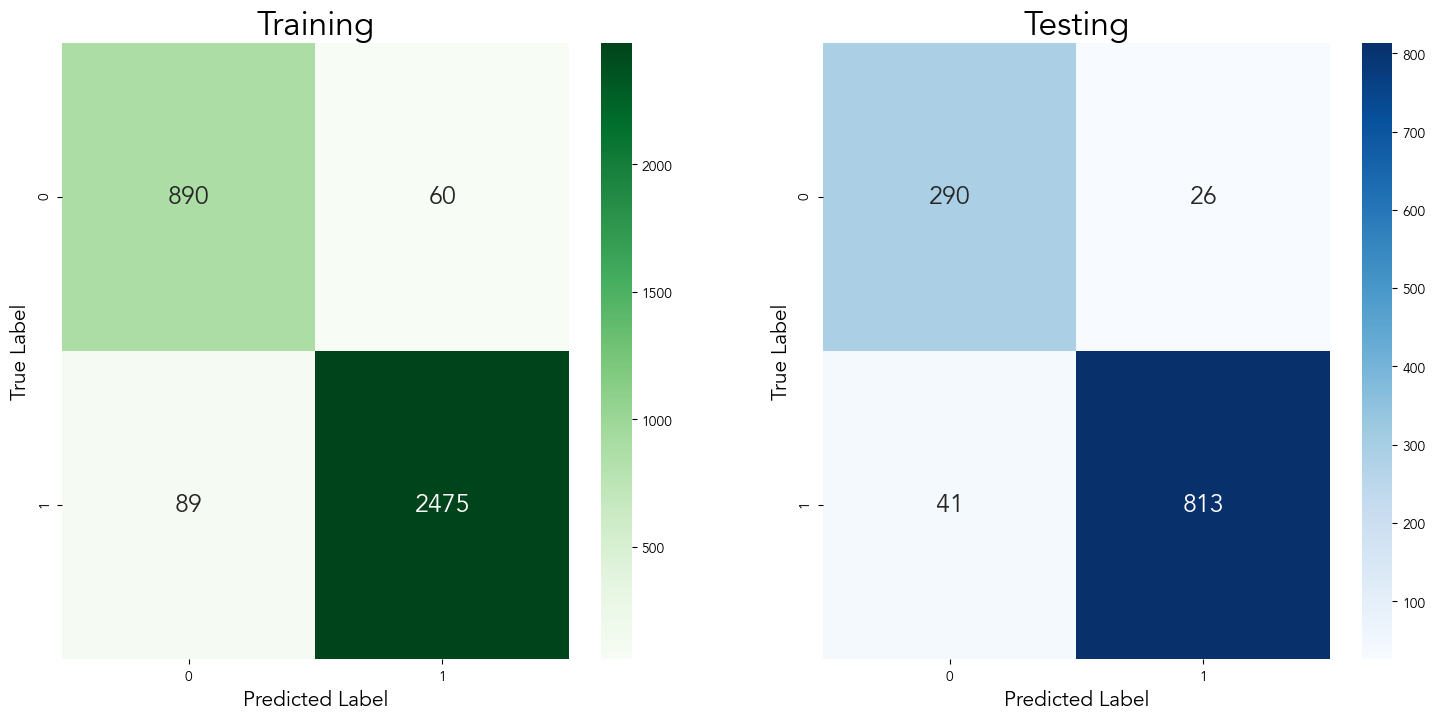

In [57]:
vis.plot_confusion_matrices(model4_1, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model4_1.png')
plt.show()

### Model 5: Base CNN with Focal Loss to solve class imbalance

In [58]:
#pip install focal-loss

In [59]:
from focal_loss import BinaryFocalLoss

In [60]:
model_fl = models.Sequential()
model_fl.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64, 1)))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_fl.add(layers.MaxPooling2D((2, 2)))

model_fl.add(layers.Flatten())
model_fl.add(layers.Dense(64, activation='relu'))
model_fl.add(layers.Dense(1, activation='sigmoid'))

model_fl.compile(
    loss=BinaryFocalLoss(gamma=2),
    optimizer= 'sgd',
    metrics=['acc']
)

In [61]:
history_base_fl = model_fl.fit(
    train_images,
    train_labels,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels)
)

pickle_history(history_base_fl, 'models/model5_hist.pkl')

Epoch 1/30
110/110 [==============================] - 7s 60ms/step - loss: 0.1551 - acc: 0.7340 - val_loss: 0.1487 - val_acc: 0.7295
Epoch 2/30
110/110 [==============================] - 7s 60ms/step - loss: 0.1512 - acc: 0.7155 - val_loss: 0.1468 - val_acc: 0.7295
Epoch 3/30
110/110 [==============================] - 7s 60ms/step - loss: 0.1443 - acc: 0.7384 - val_loss: 0.1444 - val_acc: 0.7295
Epoch 4/30
110/110 [==============================] - 7s 59ms/step - loss: 0.1438 - acc: 0.7299 - val_loss: 0.1420 - val_acc: 0.7295
Epoch 5/30
110/110 [==============================] - 7s 65ms/step - loss: 0.1422 - acc: 0.7195 - val_loss: 0.1374 - val_acc: 0.7295
Epoch 6/30
110/110 [==============================] - 7s 64ms/step - loss: 0.1353 - acc: 0.7372 - val_loss: 0.1316 - val_acc: 0.7312
Epoch 7/30
110/110 [==============================] - 7s 61ms/step - loss: 0.1269 - acc: 0.7467 - val_loss: 0.1215 - val_acc: 0.7491
Epoch 8/30
110/110 [==============================] - 7s 63ms/step - 

In [62]:
model_fl.save('models/model5.h5')

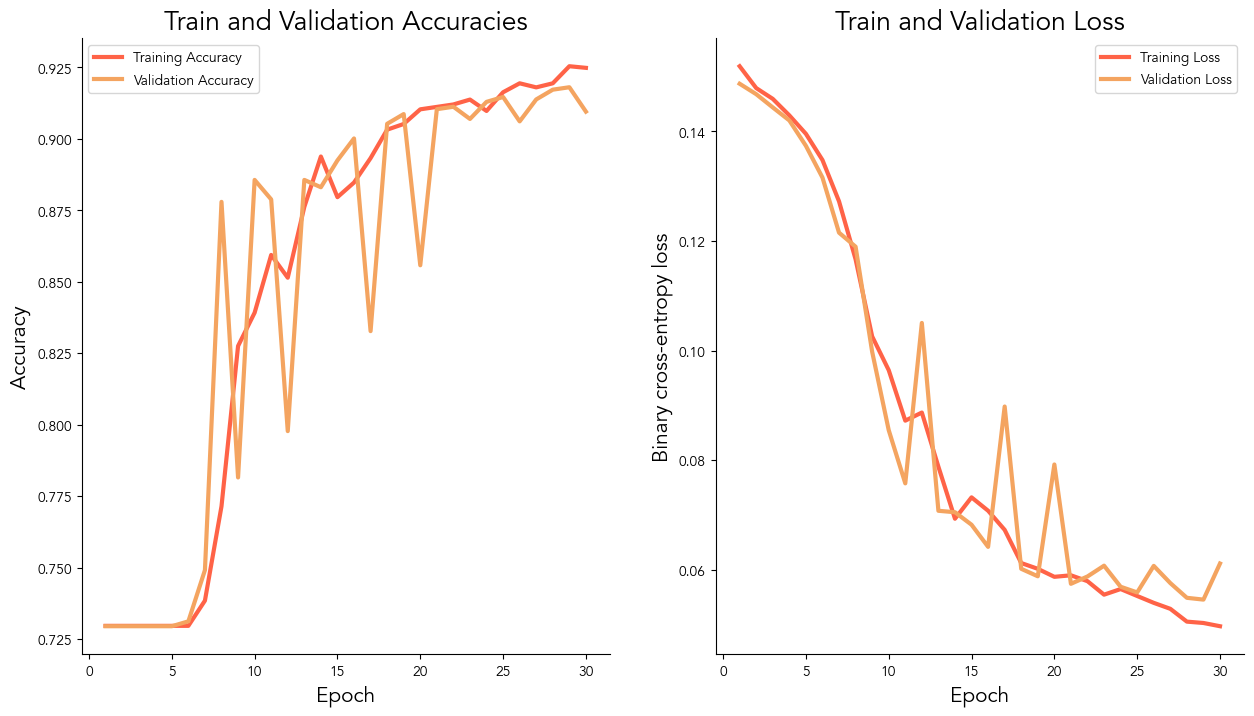

In [63]:
vis.plot_loss_accuracy(history_base_fl)
plt.savefig('images/acc_loss/al_model5.png')
plt.show()

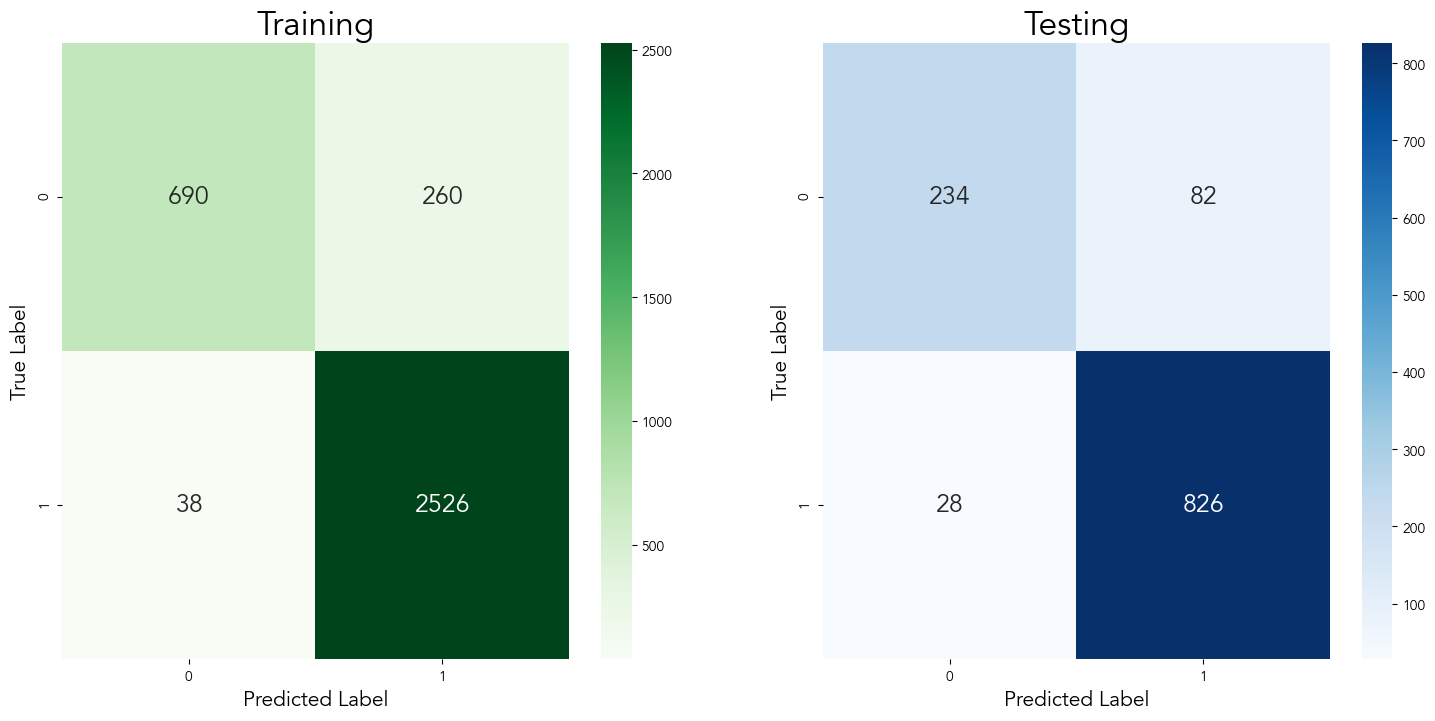

In [64]:
vis.plot_confusion_matrices(model_fl, train_images, test_images, train_labels, test_labels)
plt.savefig('images/confusion_matrices/cm_model5.png')
plt.show()

In [65]:
model_fl.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

## Evaluation, Conclusions, and Future Work

We found that the most successful model was a sequential neural network (Model 2), rather than the convolutional neural network models that were run after this. In order to improve upon the convolutional neural networks, which would likely be more accurate and have higher sensistivity (recall), these models could be further tuned with respect to their layers and kernels. However, Model 2 achieved a 98% recall on the testing data and an accuracy of 93%. 

Further iterations of this model would make use of more in-depth tuning of the convolutional models, along with a larger number of training epochs. Each of our final models were only run for 30 epochs, but this can be easily changed. However, reconfiguring the generators to be passed directly into the models may allow for more effective training and validation.